In [18]:
# Load libraries
import pandas as pd  # to read csv file 
from pandas import Series, DataFrame  # to manipulate data
import numpy as np  # to calculate with array
import matplotlib.pyplot as plt  # to plot graph
import seaborn as sns  # to visualize graph
import warnings  # to eliminate warning when plotting graph
warnings.filterwarnings('ignore')
import timeit  # to capture run time
from mlxtend.preprocessing import minmax_scaling  # for scaling data into [0, 1] range
from sklearn.feature_selection import mutual_info_classif  # the mutual information score for feature selection
from sklearn.model_selection import cross_val_score  # for cross validation in training process
from sklearn.model_selection import ParameterGrid  # to list all possible hyperparameters
from sklearn.ensemble import RandomForestClassifier  # random forest
from sklearn.naive_bayes import GaussianNB  # navie bayes
from sklearn.metrics import confusion_matrix  # for confusion matrix
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.model_selection import train_test_split # to split data into train and test
from sklearn import metrics  # for calculating accuracy

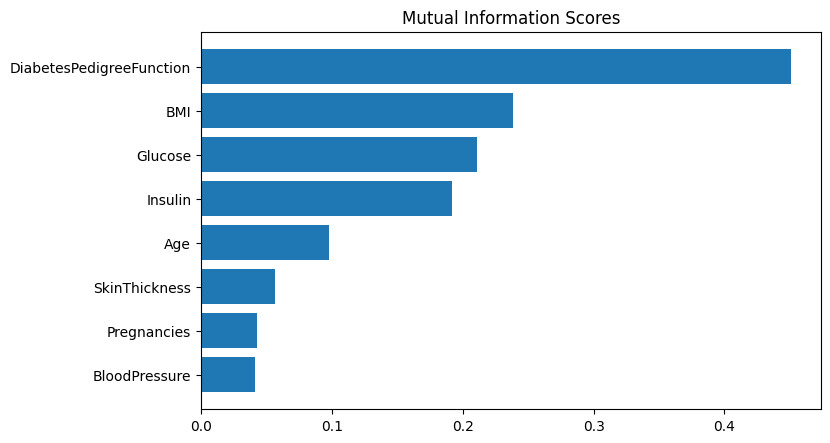

In [43]:
# all functions

def plotMIscore(data, features):
    """
        Calculate MI score and plot the top MI score.
        Input:
            data: DataFrame of all features and the outcomes
            features: list of features
        Output:
            none
    """
    # Mutual Information score
    # https://www.kaggle.com/ryanholbrook/mutual-information
    # the more MI score, the more that feature is relevant to the outcome
    mi_scores = mutual_info_classif(data[features], data['Outcome'], discrete_features=True)  # calculate MI score for discrete values
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=data[features].columns)  # transform the result into Series
    
    # plot MI score
    scores = mi_scores.sort_values(ascending=True)  # sort MI score 
    width = np.arange(len(scores))  # define width of the graph
    ticks = list(scores.index)  # define ticks of the graph
    plt.figure(dpi=100, figsize=(8, 5))  # define figure size
    plt.barh(width, scores)  # plot the graph
    plt.yticks(width, ticks)  # define y ticks
    plt.title("Mutual Information Scores")  # define title of the graph
    
def preprocess(data, scaling, features, selected_features):
    """
        Data cleaning, scaling, features selection, and splitting data into 80:20 ratio (train:test)
        Input:
            data: DataFrame of all features and the outcomes
            scaling: boolean [True: perform scaling, False: no scaling]
            features: list of all features in the dataset
            selected_features: list of selected features for features selection
        Output:
            X_train: DataFrame of features for training process
            X_test: Series of Outcomes in training process
            y_train: DataFrame of features for testing process
            y_test: Series of Outcomes in testing process
    """
    # data cleaning
    data1 = data.copy()  # copy the DataFrame
    data = data1.loc[data1["Glucose"] != 0]  # glucose con not be 0
    data = data.loc[data["BloodPressure"] != 0]  # blood pressure con not be 0
    data = data.loc[data["BMI"] != 0]  # BMI con not be 0
    data = data.loc[data["DiabetesPedigreeFunction"] <= 1]  # diabetes pedigree function is less or equal than 1
    data = data.loc[data["SkinThickness"] >= 10]  # skin thickness is greater or equal then 10 mm (Assumption)
    
    # scaling
    if scaling:
        # mix-max scale the data between 0 and 1
        for feature in features:
            data[feature] = minmax_scaling(data[feature], columns=[0])
    
    # features selection
    x = data[selected_features]
    y = data['Outcome']
    
    # train and test split with 80:20 ratio
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    return X_train, X_test, y_train, y_test

def bestModel(estimator, params, X_train, X_test, y_train, y_test, cv):
    """
        Perform cross validation for each hyperparameters configuration, calculate test accuracy,
        show the top 10 best models, and display the confusion matrix of the best model.
        Input:
            estimator: algorithm to be used
            params: dictionary of all possible hyperparameters of the specificed algorithm
            X_train: DataFrame of features for training process
            X_test: Series of Outcomes in training process
            y_train: DataFrame of features for testing process
            y_test: Series of Outcomes in testing process
            cv: numbers of cross validation
        Output:
            none
    """
    out=dict()  # dictionary to record train and test accuracy of all models
    firstIter = True  # to define if it is the first iteration or not
    record = (0,0) # to record best train and test accuracy
    for config in ParameterGrid(params):  # for each hyperparameters configuration
        clf = estimator.set_params(**config)  # set parameters 
        clf = clf.fit(X_train,y_train)  # fit the model
        all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv)  # train accuracy with cross validation
        
        # test acc
        y_pred = clf.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        
        # record the best accuracy and the y_pred
        if (test_acc, all_accuracies.mean()) >= record:
            record = (test_acc, all_accuracies.mean())
            best_y_pred = y_pred
            
        # create report dictionary
        if firstIter:  # first iteration, define values to be list
            for column in config.keys():
                out[column] = [config[column]]
            out['train_acc'] = [all_accuracies.mean()]
            out['test_acc'] = [test_acc]
            firstIter = False  # update the first iteration
        else:  # not the first iteration, add new values into the values of the dictionary
            for column in config.keys():
                out[column].append(config[column])
            out['train_acc'].append(all_accuracies.mean())
            out['test_acc'].append(test_acc)
    out.pop('n_jobs', None)  # drop the n_jobs parameters
    # sort the result by test, and train accuracy
    result = pd.DataFrame.from_dict(out).sort_values(['test_acc', 'train_acc'], ascending = [False, False])
    # show 10 records
    print(result.iloc[0:10])
    
    # generate the confusion matrix of the best model
    cf_matrix = confusion_matrix(y_test, best_y_pred)  # confusion matrix
    group_names = ['True Negative','False Positive','False Negative','True Positive']  # names tag in the matrix
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]  # values of the matrix
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]  # percentage of values
    # labels
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # create heatmap
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    # ticket labels
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    # display confusion matrix
    print()
    plt.show()
    # display the train and test accuracy of the best model
    print('train_acc: ', result.iloc[0]['train_acc'])
    print('test_acc: ', result.iloc[0]['test_acc'])
    
def iteration(dict_params):
    """
        Calculate the numbers of iterations of all hyperameter configurations.
        Input:
            dict_params: dictionary of all possible hyperparameters configurations
        Output:
            the numbers of iterations (int)
    """
    value = list(dict_params.values())  # list of all values in the dictionary
    leng = [len(i) for i in value]  # length of each values
    itera = 1  # to record the total iterations
    for i in leng:
        itera = itera*i 
    return itera

# load dataset and define features to plot MI score
data = pd.read_csv('C:\\Users\\Saeth\\Downloads\\archive\\diabetes.csv')
features = list(data.columns)
features.pop(len(features)-1)  # drop the column 'Outcome'
plotMIscore(data, features)

number of train:  389
number of test:  98

######################################################################

top 10 decision tree

    criterion  max_depth max_features splitter  train_acc  test_acc
37       gini        5.0         sqrt   random   0.668365  0.765306
157   entropy        5.0         sqrt   random   0.663203  0.765306
159   entropy        5.0         log2   random   0.668398  0.755102
45       gini        6.0         sqrt   random   0.663270  0.755102
134   entropy        2.0         log2     best   0.681185  0.744898
155   entropy        5.0         auto   random   0.670962  0.744898
149   entropy        4.0         sqrt   random   0.668432  0.744898
21       gini        3.0         sqrt   random   0.668398  0.744898
17       gini        3.0         None   random   0.663303  0.744898
151   entropy        4.0         log2   random   0.663270  0.744898



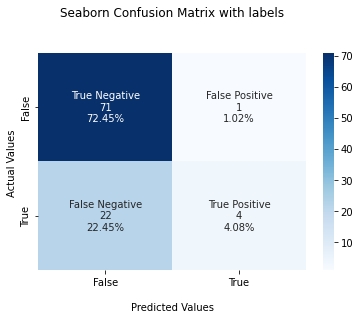

train_acc:  0.6683649683649684
test_acc:  0.7653061224489796
total run time:  3.600290100002894 Sec
Average run time per iteration:  0.01500120875001206 Sec


######################################################################

top 10 navie bayes

   priors  var_smoothing  train_acc  test_acc
41   None       0.000187   0.665834  0.755102
42   None       0.000152   0.665834  0.755102
43   None       0.000123   0.665834  0.755102
44   None       0.000100   0.665834  0.755102
45   None       0.000081   0.665834  0.755102
46   None       0.000066   0.665834  0.755102
47   None       0.000053   0.665834  0.755102
48   None       0.000043   0.665834  0.755102
49   None       0.000035   0.665834  0.755102
50   None       0.000028   0.665834  0.755102



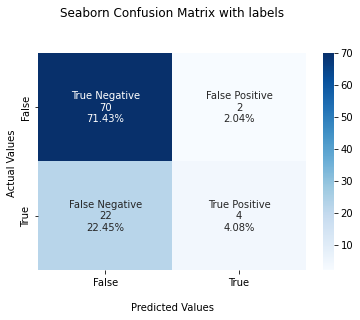

train_acc:  0.6658341658341659
test_acc:  0.7551020408163265
total run time:  1.432879399995727 Sec
Average run time per iteration:  0.01432879399995727 Sec


######################################################################

top 10 random forest

    criterion  max_depth max_features  n_estimators  train_acc  test_acc
185      gini        5.0         log2            25   0.652947  0.775510
92       gini        3.0         sqrt             5   0.678655  0.765306
355   entropy        5.0         auto            50   0.676057  0.755102
275   entropy        3.0         auto            10   0.673526  0.755102
161      gini        5.0         auto            75   0.670929  0.755102
381   entropy        5.0         log2            50   0.668365  0.755102
343   entropy        4.0         log2            75   0.660606  0.755102
93       gini        3.0         sqrt            10   0.645255  0.755102
145      gini        4.0         log2            10   0.645221  0.755102
236   entropy    

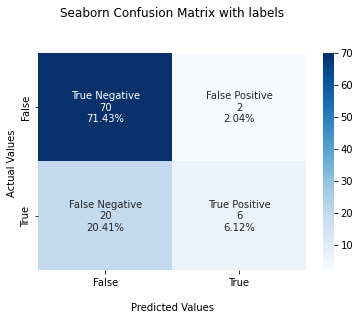

train_acc:  0.6529470529470529
test_acc:  0.7755102040816326
total run time:  344.1855055000051 Sec
Average run time per iteration:  0.8825269371795003 Sec


######################################################################



In [49]:
# main

# data preprocessing
data = pd.read_csv('C:\\Users\\Saeth\\Downloads\\archive\\diabetes.csv')  # load dataset
scailing = True  # define scaling boolean
# define features and selected_features (for features selection)
features = list(data.columns)
features.pop(len(features)-1)  # drop the column 'Outcome'
# select the features with the top 4 MI score
selected_features = ['DiabetesPedigreeFunction', 'BMI', 'Insulin', 'Glucose']  # for features selection

# define train and test dataset
X_train = preprocess(data, True, features, selected_features)[0]
X_test = preprocess(data, True, features, selected_features)[1]
y_train = preprocess(data, True, features, selected_features)[2]
y_test = preprocess(data, True, features, selected_features)[3]
print('number of train: ', X_train.shape[0])
print('number of test: ', X_test.shape[0])
print('\n' + '###################################'*2 + '\n')

# define all hyperparameters for each algorithm

# decision tree
params_DecisionTreeClassifier = {
    'max_depth': [None, 2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}

# naive bayes
params_GaussianNB = {
    'priors': [None],
    'var_smoothing': list(np.logspace(0, -9, num= 100))
}

# random forest
params_RandomForestClassifier = {
    'n_estimators': [2,5,10,25,50,75,100,150,200,250,300,400,500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2,3,4,5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_jobs': [-1]
}

# show top 10 models with the highest test and train accuracy, show confusion matrix of the best model,
# and show the total runtime with the average run time per iteration

# decision tree
print('top 10 decision tree' + '\n')
start = timeit.default_timer()
bestModel(DecisionTreeClassifier() ,params_DecisionTreeClassifier, X_train, X_test, y_train, y_test, 5)
stop = timeit.default_timer()
print('total run time: ', (stop - start), 'Sec')
print('Average run time per iteration: ', (stop - start)/iteration(params_DecisionTreeClassifier), 'Sec' + '\n') 
print('\n' + '###################################'*2 + '\n')

# naive bayes
print('top 10 navie bayes' + '\n')
start = timeit.default_timer()
bestModel(GaussianNB() ,params_GaussianNB, X_train, X_test, y_train, y_test, 5)
stop = timeit.default_timer()
print('total run time: ', (stop - start), 'Sec')
print('Average run time per iteration: ', (stop - start)/iteration(params_GaussianNB), 'Sec' + '\n') 
print('\n' + '###################################'*2 + '\n')

# random forest
print('top 10 random forest' + '\n')
start = timeit.default_timer()
bestModel(RandomForestClassifier() ,params_RandomForestClassifier, X_train, X_test, y_train, y_test, 5)
stop = timeit.default_timer()
print('total run time: ', (stop - start), 'Sec')
print('Average run time per iteration: ', (stop - start)/iteration(params_RandomForestClassifier), 'Sec' + '\n') 
print('\n' + '###################################'*2 + '\n')